In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(553799, 828)
(553799, 1)
validation
(80986, 828)
(80986, 1)
test
(65261, 828)
(65261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/56 [..............................] - ETA: 1:28 - loss: 0.1966 - STD: 1.3973e-04 - MAE: 0.4315

 2/56 [>.............................] - ETA: 37s - loss: 0.1543 - STD: 2.9256e-04 - MAE: 0.3104 

 5/56 [=>............................] - ETA: 9s - loss: 0.0592 - STD: 2.8197e-04 - MAE: 0.1798 

 6/56 [==>...........................] - ETA: 8s - loss: 0.0528 - STD: 2.4942e-04 - MAE: 0.1704

 7/56 [==>...........................] - ETA: 7s - loss: 0.0490 - STD: 2.2150e-04 - MAE: 0.1654

 8/56 [===>..........................] - ETA: 6s - loss: 0.0464 - STD: 1.9814e-04 - MAE: 0.1622

 9/56 [===>..........................] - ETA: 6s - loss: 0.0445 - STD: 1.7863e-04 - MAE: 0.1599

10/56 [====>.........................] - ETA: 5s - loss: 0.0431 - STD: 1.6223e-04 - MAE: 0.1583

11/56 [====>.........................] - ETA: 5s - loss: 0.0420 - STD: 1.4832e-04 - MAE: 0.1572

12/56 [=====>........................] - ETA: 5s - loss: 0.0411 - STD: 1.3648e-04 - MAE: 0.1564

13/56 [=====>........................] - ETA: 4s - loss: 0.0403 - STD: 1.2646e-04 - MAE: 0.1554

14/56 [======>.......................] - ETA: 4s - loss: 0.0396 - STD: 1.1803e-04 - MAE: 0.1545

15/56 [=======>......................] - ETA: 4s - loss: 0.0389 - STD: 1.1087e-04 - MAE: 0.1534

16/56 [=======>......................] - ETA: 4s - loss: 0.0382 - STD: 1.0477e-04 - MAE: 0.1523

17/56 [========>.....................] - ETA: 3s - loss: 0.0375 - STD: 9.9499e-05 - MAE: 0.1511

18/56 [========>.....................] - ETA: 3s - loss: 0.0369 - STD: 9.4917e-05 - MAE: 0.1498

19/56 [=========>....................] - ETA: 3s - loss: 0.0362 - STD: 9.0927e-05 - MAE: 0.1484

20/56 [=========>....................] - ETA: 3s - loss: 0.0355 - STD: 8.7418e-05 - MAE: 0.1468

21/56 [==========>...................] - ETA: 3s - loss: 0.0348 - STD: 8.4354e-05 - MAE: 0.1449

22/56 [==========>...................] - ETA: 3s - loss: 0.0341 - STD: 8.1648e-05 - MAE: 0.1430

23/56 [===========>..................] - ETA: 2s - loss: 0.0333 - STD: 7.9265e-05 - MAE: 0.1409

24/56 [===========>..................] - ETA: 2s - loss: 0.0325 - STD: 7.7175e-05 - MAE: 0.1387

25/56 [============>.................] - ETA: 2s - loss: 0.0318 - STD: 7.5347e-05 - MAE: 0.1364

26/56 [============>.................] - ETA: 2s - loss: 0.0310 - STD: 7.3735e-05 - MAE: 0.1343

27/56 [=============>................] - ETA: 2s - loss: 0.0302 - STD: 7.2354e-05 - MAE: 0.1322

28/56 [==============>...............] - ETA: 2s - loss: 0.0295 - STD: 7.1115e-05 - MAE: 0.1303

29/56 [==============>...............] - ETA: 2s - loss: 0.0289 - STD: 6.9991e-05 - MAE: 0.1288

30/56 [===============>..............] - ETA: 2s - loss: 0.0283 - STD: 6.8949e-05 - MAE: 0.1275

31/56 [===============>..............] - ETA: 2s - loss: 0.0278 - STD: 6.7955e-05 - MAE: 0.1265

32/56 [================>.............] - ETA: 2s - loss: 0.0273 - STD: 6.6982e-05 - MAE: 0.1256

33/56 [================>.............] - ETA: 1s - loss: 0.0269 - STD: 6.6010e-05 - MAE: 0.1249

34/56 [=================>............] - ETA: 1s - loss: 0.0265 - STD: 6.5026e-05 - MAE: 0.1241

35/56 [=================>............] - ETA: 1s - loss: 0.0261 - STD: 6.3998e-05 - MAE: 0.1234

36/56 [==================>...........] - ETA: 1s - loss: 0.0257 - STD: 6.2929e-05 - MAE: 0.1225

37/56 [==================>...........] - ETA: 1s - loss: 0.0253 - STD: 6.1832e-05 - MAE: 0.1216

38/56 [===================>..........] - ETA: 1s - loss: 0.0250 - STD: 6.0725e-05 - MAE: 0.1207

39/56 [===================>..........] - ETA: 1s - loss: 0.0246 - STD: 5.9622e-05 - MAE: 0.1197

40/56 [====================>.........] - ETA: 1s - loss: 0.0242 - STD: 5.8527e-05 - MAE: 0.1187

41/56 [====================>.........] - ETA: 1s - loss: 0.0239 - STD: 5.7453e-05 - MAE: 0.1177

42/56 [=====================>........] - ETA: 1s - loss: 0.0236 - STD: 5.6412e-05 - MAE: 0.1168

43/56 [======================>.......] - ETA: 1s - loss: 0.0233 - STD: 5.5408e-05 - MAE: 0.1159

44/56 [======================>.......] - ETA: 0s - loss: 0.0230 - STD: 5.4439e-05 - MAE: 0.1150

45/56 [=======================>......] - ETA: 0s - loss: 0.0227 - STD: 5.3514e-05 - MAE: 0.1142

46/56 [=======================>......] - ETA: 0s - loss: 0.0225 - STD: 5.2629e-05 - MAE: 0.1134

47/56 [========================>.....] - ETA: 0s - loss: 0.0222 - STD: 5.1782e-05 - MAE: 0.1127

48/56 [========================>.....] - ETA: 0s - loss: 0.0220 - STD: 5.0971e-05 - MAE: 0.1120

49/56 [=========================>....] - ETA: 0s - loss: 0.0218 - STD: 5.0200e-05 - MAE: 0.1113

50/56 [=========================>....] - ETA: 0s - loss: 0.0216 - STD: 4.9468e-05 - MAE: 0.1106

51/56 [==========================>...] - ETA: 0s - loss: 0.0214 - STD: 4.8771e-05 - MAE: 0.1100

52/56 [==========================>...] - ETA: 0s - loss: 0.0212 - STD: 4.8106e-05 - MAE: 0.1094

53/56 [===========================>..] - ETA: 0s - loss: 0.0210 - STD: 4.7476e-05 - MAE: 0.1088

54/56 [===========================>..] - ETA: 0s - loss: 0.0208 - STD: 4.6874e-05 - MAE: 0.1083

55/56 [============================>.] - ETA: 0s - loss: 0.0206 - STD: 4.6301e-05 - MAE: 0.1078

56/56 [==============================] - ETA: 0s - loss: 0.0204 - STD: 4.5754e-05 - MAE: 0.1073

56/56 [==============================] - 6s 89ms/step - loss: 0.0204 - STD: 4.5754e-05 - MAE: 0.1073 - val_loss: 0.0119 - val_STD: 1.4128e-05 - val_MAE: 0.0825


Epoch 2/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0105 - STD: 1.5959e-05 - MAE: 0.0812

 2/56 [>.............................] - ETA: 3s - loss: 0.0107 - STD: 1.5972e-05 - MAE: 0.0822

 3/56 [>.............................] - ETA: 3s - loss: 0.0107 - STD: 1.6220e-05 - MAE: 0.0824

 4/56 [=>............................] - ETA: 3s - loss: 0.0107 - STD: 1.6396e-05 - MAE: 0.0827

 5/56 [=>............................] - ETA: 3s - loss: 0.0108 - STD: 1.6549e-05 - MAE: 0.0829

 6/56 [==>...........................] - ETA: 3s - loss: 0.0108 - STD: 1.6677e-05 - MAE: 0.0830

 7/56 [==>...........................] - ETA: 3s - loss: 0.0108 - STD: 1.6819e-05 - MAE: 0.0830

 9/56 [===>..........................] - ETA: 2s - loss: 0.0108 - STD: 1.7001e-05 - MAE: 0.0826

10/56 [====>.........................] - ETA: 2s - loss: 0.0108 - STD: 1.7102e-05 - MAE: 0.0824

11/56 [====>.........................] - ETA: 2s - loss: 0.0108 - STD: 1.7222e-05 - MAE: 0.0823

12/56 [=====>........................] - ETA: 2s - loss: 0.0108 - STD: 1.7317e-05 - MAE: 0.0821

13/56 [=====>........................] - ETA: 2s - loss: 0.0108 - STD: 1.7429e-05 - MAE: 0.0820

14/56 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 1.7522e-05 - MAE: 0.0818

15/56 [=======>......................] - ETA: 2s - loss: 0.0108 - STD: 1.7604e-05 - MAE: 0.0816

16/56 [=======>......................] - ETA: 2s - loss: 0.0108 - STD: 1.7710e-05 - MAE: 0.0815

17/56 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 1.7825e-05 - MAE: 0.0814

18/56 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 1.7941e-05 - MAE: 0.0813

19/56 [=========>....................] - ETA: 2s - loss: 0.0108 - STD: 1.8060e-05 - MAE: 0.0812

20/56 [=========>....................] - ETA: 2s - loss: 0.0108 - STD: 1.8197e-05 - MAE: 0.0811

21/56 [==========>...................] - ETA: 2s - loss: 0.0108 - STD: 1.8329e-05 - MAE: 0.0811

22/56 [==========>...................] - ETA: 2s - loss: 0.0108 - STD: 1.8472e-05 - MAE: 0.0810

23/56 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 1.8624e-05 - MAE: 0.0809

24/56 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 1.8773e-05 - MAE: 0.0809

25/56 [============>.................] - ETA: 2s - loss: 0.0107 - STD: 1.8939e-05 - MAE: 0.0808

26/56 [============>.................] - ETA: 1s - loss: 0.0107 - STD: 1.9101e-05 - MAE: 0.0808

27/56 [=============>................] - ETA: 1s - loss: 0.0107 - STD: 1.9270e-05 - MAE: 0.0808

28/56 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 1.9439e-05 - MAE: 0.0808

29/56 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 1.9619e-05 - MAE: 0.0808

30/56 [===============>..............] - ETA: 1s - loss: 0.0107 - STD: 1.9794e-05 - MAE: 0.0808

31/56 [===============>..............] - ETA: 1s - loss: 0.0107 - STD: 1.9970e-05 - MAE: 0.0808

32/56 [================>.............] - ETA: 1s - loss: 0.0107 - STD: 2.0149e-05 - MAE: 0.0808

33/56 [================>.............] - ETA: 1s - loss: 0.0107 - STD: 2.0325e-05 - MAE: 0.0808

34/56 [=================>............] - ETA: 1s - loss: 0.0107 - STD: 2.0500e-05 - MAE: 0.0808

35/56 [=================>............] - ETA: 1s - loss: 0.0107 - STD: 2.0669e-05 - MAE: 0.0808

36/56 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 2.0852e-05 - MAE: 0.0807

37/56 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 2.1029e-05 - MAE: 0.0807

38/56 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 2.1202e-05 - MAE: 0.0807

39/56 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 2.1379e-05 - MAE: 0.0807

40/56 [====================>.........] - ETA: 1s - loss: 0.0107 - STD: 2.1566e-05 - MAE: 0.0806

41/56 [====================>.........] - ETA: 0s - loss: 0.0107 - STD: 2.1748e-05 - MAE: 0.0806

42/56 [=====================>........] - ETA: 0s - loss: 0.0107 - STD: 2.1940e-05 - MAE: 0.0806

43/56 [======================>.......] - ETA: 0s - loss: 0.0107 - STD: 2.2135e-05 - MAE: 0.0806

44/56 [======================>.......] - ETA: 0s - loss: 0.0107 - STD: 2.2330e-05 - MAE: 0.0806

45/56 [=======================>......] - ETA: 0s - loss: 0.0107 - STD: 2.2534e-05 - MAE: 0.0806

46/56 [=======================>......] - ETA: 0s - loss: 0.0107 - STD: 2.2736e-05 - MAE: 0.0806

47/56 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 2.2940e-05 - MAE: 0.0806

48/56 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 2.3143e-05 - MAE: 0.0805

49/56 [=========================>....] - ETA: 0s - loss: 0.0107 - STD: 2.3360e-05 - MAE: 0.0805

50/56 [=========================>....] - ETA: 0s - loss: 0.0107 - STD: 2.3580e-05 - MAE: 0.0805

51/56 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 2.3796e-05 - MAE: 0.0805

52/56 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 2.4016e-05 - MAE: 0.0805

53/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.4229e-05 - MAE: 0.0805

54/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.4452e-05 - MAE: 0.0805

55/56 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 2.4681e-05 - MAE: 0.0805

56/56 [==============================] - ETA: 0s - loss: 0.0106 - STD: 2.4918e-05 - MAE: 0.0805

56/56 [==============================] - 4s 70ms/step - loss: 0.0106 - STD: 2.4918e-05 - MAE: 0.0805 - val_loss: 0.0119 - val_STD: 3.2652e-05 - val_MAE: 0.0810


Epoch 3/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0105 - STD: 3.8351e-05 - MAE: 0.0797

 2/56 [>.............................] - ETA: 3s - loss: 0.0106 - STD: 3.8506e-05 - MAE: 0.0800

 3/56 [>.............................] - ETA: 3s - loss: 0.0106 - STD: 3.8813e-05 - MAE: 0.0799

 4/56 [=>............................] - ETA: 3s - loss: 0.0107 - STD: 3.9136e-05 - MAE: 0.0803

 5/56 [=>............................] - ETA: 3s - loss: 0.0107 - STD: 3.9378e-05 - MAE: 0.0802

 6/56 [==>...........................] - ETA: 3s - loss: 0.0107 - STD: 3.9721e-05 - MAE: 0.0803

 7/56 [==>...........................] - ETA: 3s - loss: 0.0107 - STD: 4.0119e-05 - MAE: 0.0804

 8/56 [===>..........................] - ETA: 3s - loss: 0.0107 - STD: 4.0437e-05 - MAE: 0.0803

 9/56 [===>..........................] - ETA: 3s - loss: 0.0107 - STD: 4.0826e-05 - MAE: 0.0803

10/56 [====>.........................] - ETA: 3s - loss: 0.0107 - STD: 4.1179e-05 - MAE: 0.0802

11/56 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 4.1591e-05 - MAE: 0.0802

12/56 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 4.1969e-05 - MAE: 0.0802

13/56 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 4.2339e-05 - MAE: 0.0802

14/56 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 4.2708e-05 - MAE: 0.0802

15/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 4.3067e-05 - MAE: 0.0802

16/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 4.3458e-05 - MAE: 0.0802

17/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 4.3876e-05 - MAE: 0.0802

18/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 4.4280e-05 - MAE: 0.0802

19/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 4.4676e-05 - MAE: 0.0802

20/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 4.5049e-05 - MAE: 0.0802

21/56 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 4.5463e-05 - MAE: 0.0801

22/56 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 4.5882e-05 - MAE: 0.0801

23/56 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 4.6292e-05 - MAE: 0.0801

24/56 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 4.6716e-05 - MAE: 0.0801

25/56 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 4.7158e-05 - MAE: 0.0801

26/56 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 4.7596e-05 - MAE: 0.0802

27/56 [=============>................] - ETA: 1s - loss: 0.0106 - STD: 4.8050e-05 - MAE: 0.0802

28/56 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 4.8508e-05 - MAE: 0.0801

29/56 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 4.8986e-05 - MAE: 0.0801

30/56 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 4.9460e-05 - MAE: 0.0801

31/56 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 4.9948e-05 - MAE: 0.0801

32/56 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 5.0461e-05 - MAE: 0.0801

33/56 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 5.0935e-05 - MAE: 0.0801

34/56 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 5.1444e-05 - MAE: 0.0801

35/56 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 5.1946e-05 - MAE: 0.0801

36/56 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 5.2472e-05 - MAE: 0.0801

37/56 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 5.3016e-05 - MAE: 0.0801

38/56 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 5.3516e-05 - MAE: 0.0801

40/56 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 5.4610e-05 - MAE: 0.0800

41/56 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 5.5160e-05 - MAE: 0.0800

42/56 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 5.5723e-05 - MAE: 0.0801

43/56 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 5.6303e-05 - MAE: 0.0800

44/56 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 5.6891e-05 - MAE: 0.0800

45/56 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 5.7490e-05 - MAE: 0.0801

46/56 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 5.8113e-05 - MAE: 0.0800

47/56 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 5.8729e-05 - MAE: 0.0800

48/56 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 5.9380e-05 - MAE: 0.0801

49/56 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 6.0027e-05 - MAE: 0.0801

50/56 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 6.0692e-05 - MAE: 0.0801

51/56 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 6.1356e-05 - MAE: 0.0801

52/56 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 6.2047e-05 - MAE: 0.0801

53/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 6.2751e-05 - MAE: 0.0801

54/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 6.3468e-05 - MAE: 0.0801

55/56 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 6.4176e-05 - MAE: 0.0801

56/56 [==============================] - ETA: 0s - loss: 0.0106 - STD: 6.4905e-05 - MAE: 0.0801

56/56 [==============================] - 4s 70ms/step - loss: 0.0106 - STD: 6.4905e-05 - MAE: 0.0801 - val_loss: 0.0119 - val_STD: 9.1119e-05 - val_MAE: 0.0810


Epoch 4/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0107 - STD: 1.0661e-04 - MAE: 0.0801

 2/56 [>.............................] - ETA: 3s - loss: 0.0105 - STD: 1.0803e-04 - MAE: 0.0798

 3/56 [>.............................] - ETA: 3s - loss: 0.0105 - STD: 1.0946e-04 - MAE: 0.0796

 4/56 [=>............................] - ETA: 3s - loss: 0.0105 - STD: 1.1084e-04 - MAE: 0.0797

 5/56 [=>............................] - ETA: 3s - loss: 0.0106 - STD: 1.1199e-04 - MAE: 0.0798

 6/56 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 1.1298e-04 - MAE: 0.0797

 7/56 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 1.1429e-04 - MAE: 0.0797

 8/56 [===>..........................] - ETA: 3s - loss: 0.0105 - STD: 1.1565e-04 - MAE: 0.0798

 9/56 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 1.1694e-04 - MAE: 0.0799

10/56 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 1.1823e-04 - MAE: 0.0799

11/56 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 1.1979e-04 - MAE: 0.0800

12/56 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 1.2133e-04 - MAE: 0.0801

13/56 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 1.2281e-04 - MAE: 0.0801

14/56 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 1.2432e-04 - MAE: 0.0802

15/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 1.2578e-04 - MAE: 0.0802

16/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 1.2730e-04 - MAE: 0.0801

17/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 1.2885e-04 - MAE: 0.0801

18/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 1.3054e-04 - MAE: 0.0801

19/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 1.3220e-04 - MAE: 0.0801

20/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 1.3389e-04 - MAE: 0.0801

21/56 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 1.3564e-04 - MAE: 0.0801

22/56 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 1.3737e-04 - MAE: 0.0800

23/56 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 1.3914e-04 - MAE: 0.0800

24/56 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 1.4093e-04 - MAE: 0.0800

25/56 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 1.4288e-04 - MAE: 0.0800

26/56 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 1.4479e-04 - MAE: 0.0800

27/56 [=============>................] - ETA: 1s - loss: 0.0106 - STD: 1.4677e-04 - MAE: 0.0800

28/56 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 1.4880e-04 - MAE: 0.0800

29/56 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 1.5088e-04 - MAE: 0.0800

30/56 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 1.5302e-04 - MAE: 0.0800

31/56 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 1.5518e-04 - MAE: 0.0800

33/56 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 1.5978e-04 - MAE: 0.0801

34/56 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 1.6214e-04 - MAE: 0.0801

35/56 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 1.6455e-04 - MAE: 0.0801

36/56 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 1.6711e-04 - MAE: 0.0801

37/56 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 1.6971e-04 - MAE: 0.0801

38/56 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 1.7233e-04 - MAE: 0.0801

39/56 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 1.7500e-04 - MAE: 0.0801

40/56 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 1.7772e-04 - MAE: 0.0801

41/56 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 1.8058e-04 - MAE: 0.0801

42/56 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 1.8344e-04 - MAE: 0.0801

43/56 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 1.8637e-04 - MAE: 0.0801

44/56 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 1.8944e-04 - MAE: 0.0801

45/56 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.9256e-04 - MAE: 0.0801

46/56 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.9583e-04 - MAE: 0.0801

47/56 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 1.9902e-04 - MAE: 0.0801

48/56 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 2.0237e-04 - MAE: 0.0801

49/56 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 2.0586e-04 - MAE: 0.0801

50/56 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 2.0948e-04 - MAE: 0.0801

51/56 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 2.1318e-04 - MAE: 0.0801

52/56 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 2.1699e-04 - MAE: 0.0801

53/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.2091e-04 - MAE: 0.0801

54/56 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.2488e-04 - MAE: 0.0801

55/56 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 2.2905e-04 - MAE: 0.0801

56/56 [==============================] - ETA: 0s - loss: 0.0106 - STD: 2.3326e-04 - MAE: 0.0801

56/56 [==============================] - 4s 71ms/step - loss: 0.0106 - STD: 2.3326e-04 - MAE: 0.0801 - val_loss: 0.0118 - val_STD: 4.0760e-04 - val_MAE: 0.0809


Epoch 5/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0103 - STD: 4.8419e-04 - MAE: 0.0793

 2/56 [>.............................] - ETA: 3s - loss: 0.0106 - STD: 4.9068e-04 - MAE: 0.0798

 3/56 [>.............................] - ETA: 3s - loss: 0.0106 - STD: 4.9815e-04 - MAE: 0.0798

 4/56 [=>............................] - ETA: 3s - loss: 0.0106 - STD: 5.0782e-04 - MAE: 0.0799

 5/56 [=>............................] - ETA: 3s - loss: 0.0105 - STD: 5.1681e-04 - MAE: 0.0798

 6/56 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 5.2482e-04 - MAE: 0.0797

 7/56 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 5.3409e-04 - MAE: 0.0797

 8/56 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 5.4411e-04 - MAE: 0.0798

 9/56 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 5.5363e-04 - MAE: 0.0798

10/56 [====>.........................] - ETA: 2s - loss: 0.0105 - STD: 5.6402e-04 - MAE: 0.0797

11/56 [====>.........................] - ETA: 2s - loss: 0.0106 - STD: 5.7440e-04 - MAE: 0.0798

12/56 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 5.8517e-04 - MAE: 0.0799

13/56 [=====>........................] - ETA: 2s - loss: 0.0105 - STD: 5.9607e-04 - MAE: 0.0798

14/56 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 6.0809e-04 - MAE: 0.0799

15/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 6.2061e-04 - MAE: 0.0799

16/56 [=======>......................] - ETA: 2s - loss: 0.0106 - STD: 6.3338e-04 - MAE: 0.0800

17/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 6.4670e-04 - MAE: 0.0800

18/56 [========>.....................] - ETA: 2s - loss: 0.0106 - STD: 6.6033e-04 - MAE: 0.0800

19/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 6.7463e-04 - MAE: 0.0800

20/56 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 6.8872e-04 - MAE: 0.0800

21/56 [==========>...................] - ETA: 2s - loss: 0.0105 - STD: 7.0391e-04 - MAE: 0.0800

22/56 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 7.1922e-04 - MAE: 0.0800

23/56 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 7.3500e-04 - MAE: 0.0800

24/56 [===========>..................] - ETA: 2s - loss: 0.0105 - STD: 7.5088e-04 - MAE: 0.0800

25/56 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 7.6790e-04 - MAE: 0.0800

26/56 [============>.................] - ETA: 1s - loss: 0.0105 - STD: 7.8554e-04 - MAE: 0.0800

27/56 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 8.0359e-04 - MAE: 0.0800

28/56 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 8.2237e-04 - MAE: 0.0799

29/56 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 8.4168e-04 - MAE: 0.0799

30/56 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 8.6174e-04 - MAE: 0.0799

31/56 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 8.8273e-04 - MAE: 0.0799

32/56 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 9.0405e-04 - MAE: 0.0799

33/56 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 9.2620e-04 - MAE: 0.0799

34/56 [=================>............] - ETA: 1s - loss: 0.0105 - STD: 9.4962e-04 - MAE: 0.0798

35/56 [=================>............] - ETA: 1s - loss: 0.0105 - STD: 9.7431e-04 - MAE: 0.0798

36/56 [==================>...........] - ETA: 1s - loss: 0.0105 - STD: 9.9939e-04 - MAE: 0.0798

37/56 [==================>...........] - ETA: 1s - loss: 0.0105 - STD: 0.0010 - MAE: 0.0798    

38/56 [===================>..........] - ETA: 1s - loss: 0.0105 - STD: 0.0011 - MAE: 0.0798

39/56 [===================>..........] - ETA: 1s - loss: 0.0105 - STD: 0.0011 - MAE: 0.0798

40/56 [====================>.........] - ETA: 1s - loss: 0.0105 - STD: 0.0011 - MAE: 0.0798

41/56 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 0.0011 - MAE: 0.0798

42/56 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 0.0012 - MAE: 0.0797

43/56 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.0012 - MAE: 0.0798

44/56 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.0012 - MAE: 0.0797

46/56 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.0013 - MAE: 0.0797

47/56 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.0013 - MAE: 0.0797

48/56 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0797

49/56 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0797

50/56 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0797

51/56 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0797

52/56 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0797

53/56 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0797

54/56 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0797

55/56 [============================>.] - ETA: 0s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0797

56/56 [==============================] - ETA: 0s - loss: 0.0105 - STD: 0.0018 - MAE: 0.0796

56/56 [==============================] - 4s 70ms/step - loss: 0.0105 - STD: 0.0018 - MAE: 0.0796 - val_loss: 0.0114 - val_STD: 0.0043 - val_MAE: 0.0796


Epoch 6/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0104 - STD: 0.0050 - MAE: 0.0797

 2/56 [>.............................] - ETA: 3s - loss: 0.0102 - STD: 0.0051 - MAE: 0.0790

 3/56 [>.............................] - ETA: 3s - loss: 0.0101 - STD: 0.0053 - MAE: 0.0787

 4/56 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 0.0054 - MAE: 0.0784

 5/56 [=>............................] - ETA: 3s - loss: 0.0101 - STD: 0.0056 - MAE: 0.0784

 6/56 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 0.0057 - MAE: 0.0784

 7/56 [==>...........................] - ETA: 3s - loss: 0.0101 - STD: 0.0058 - MAE: 0.0783

 8/56 [===>..........................] - ETA: 3s - loss: 0.0101 - STD: 0.0060 - MAE: 0.0782

 9/56 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 0.0061 - MAE: 0.0781

10/56 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 0.0063 - MAE: 0.0781

11/56 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 0.0064 - MAE: 0.0781

12/56 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 0.0066 - MAE: 0.0781

13/56 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 0.0068 - MAE: 0.0781

14/56 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 0.0070 - MAE: 0.0781

15/56 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 0.0071 - MAE: 0.0780

16/56 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 0.0073 - MAE: 0.0780

17/56 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0075 - MAE: 0.0780

18/56 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0077 - MAE: 0.0780

19/56 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 0.0079 - MAE: 0.0779

20/56 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 0.0081 - MAE: 0.0778

21/56 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 0.0084 - MAE: 0.0778

22/56 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 0.0086 - MAE: 0.0777

23/56 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0088 - MAE: 0.0777

24/56 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0090 - MAE: 0.0776

25/56 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 0.0093 - MAE: 0.0775

26/56 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0095 - MAE: 0.0775

27/56 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0098 - MAE: 0.0774

28/56 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0100 - MAE: 0.0773

29/56 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0103 - MAE: 0.0772

30/56 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0105 - MAE: 0.0772

31/56 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0108 - MAE: 0.0771

32/56 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0111 - MAE: 0.0771

33/56 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0114 - MAE: 0.0770

34/56 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0116 - MAE: 0.0770

35/56 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0119 - MAE: 0.0769

36/56 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.0122 - MAE: 0.0769

37/56 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.0125 - MAE: 0.0768

38/56 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.0128 - MAE: 0.0767

39/56 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.0131 - MAE: 0.0766

40/56 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0134 - MAE: 0.0766

41/56 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0138 - MAE: 0.0765

42/56 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0141 - MAE: 0.0764

43/56 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0144 - MAE: 0.0763

44/56 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0147 - MAE: 0.0763

45/56 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0150 - MAE: 0.0762

46/56 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0153 - MAE: 0.0761

47/56 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0156 - MAE: 0.0760

48/56 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0160 - MAE: 0.0759

49/56 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0163 - MAE: 0.0759

50/56 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0166 - MAE: 0.0758

51/56 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0169 - MAE: 0.0757

52/56 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0172 - MAE: 0.0756

54/56 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0178 - MAE: 0.0755

55/56 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0181 - MAE: 0.0754

56/56 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0184 - MAE: 0.0753

56/56 [==============================] - 4s 71ms/step - loss: 0.0094 - STD: 0.0184 - MAE: 0.0753 - val_loss: 0.0092 - val_STD: 0.0309 - val_MAE: 0.0703


Epoch 7/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0083 - STD: 0.0357 - MAE: 0.0699

 2/56 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.0362 - MAE: 0.0702

 3/56 [>.............................] - ETA: 3s - loss: 0.0083 - STD: 0.0365 - MAE: 0.0701

 4/56 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0367 - MAE: 0.0704

 5/56 [=>............................] - ETA: 3s - loss: 0.0083 - STD: 0.0370 - MAE: 0.0701

 6/56 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0372 - MAE: 0.0700

 7/56 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0375 - MAE: 0.0699

 8/56 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0378 - MAE: 0.0698

 9/56 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0379 - MAE: 0.0699

10/56 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0380 - MAE: 0.0699

11/56 [====>.........................] - ETA: 3s - loss: 0.0082 - STD: 0.0382 - MAE: 0.0698

12/56 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.0384 - MAE: 0.0697

13/56 [=====>........................] - ETA: 2s - loss: 0.0082 - STD: 0.0385 - MAE: 0.0695

14/56 [======>.......................] - ETA: 2s - loss: 0.0082 - STD: 0.0387 - MAE: 0.0695

15/56 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0388 - MAE: 0.0694

16/56 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0390 - MAE: 0.0693

17/56 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0391 - MAE: 0.0692

18/56 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0392 - MAE: 0.0691

19/56 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0394 - MAE: 0.0690

20/56 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0396 - MAE: 0.0689

21/56 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.0398 - MAE: 0.0689

22/56 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0400 - MAE: 0.0688

23/56 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0401 - MAE: 0.0686

24/56 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0403 - MAE: 0.0685

25/56 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.0406 - MAE: 0.0684

26/56 [============>.................] - ETA: 2s - loss: 0.0079 - STD: 0.0408 - MAE: 0.0683

27/56 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0410 - MAE: 0.0682

28/56 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0412 - MAE: 0.0681

29/56 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0415 - MAE: 0.0680

30/56 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0417 - MAE: 0.0679

31/56 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0419 - MAE: 0.0678

32/56 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0422 - MAE: 0.0676

33/56 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0424 - MAE: 0.0675

34/56 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0426 - MAE: 0.0674

35/56 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0428 - MAE: 0.0673

36/56 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0430 - MAE: 0.0672

37/56 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0433 - MAE: 0.0671

38/56 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0434 - MAE: 0.0669

39/56 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0437 - MAE: 0.0669

40/56 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0440 - MAE: 0.0667

41/56 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0441 - MAE: 0.0666

42/56 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0444 - MAE: 0.0665

43/56 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0446 - MAE: 0.0664

44/56 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0448 - MAE: 0.0662

45/56 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0451 - MAE: 0.0661

46/56 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0454 - MAE: 0.0660

47/56 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0456 - MAE: 0.0659

48/56 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0458 - MAE: 0.0659

49/56 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0461 - MAE: 0.0657

50/56 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0463 - MAE: 0.0656

51/56 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0465 - MAE: 0.0655

52/56 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0468 - MAE: 0.0655

54/56 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0472 - MAE: 0.0653

55/56 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0475 - MAE: 0.0652

56/56 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0477 - MAE: 0.0651

56/56 [==============================] - 4s 71ms/step - loss: 0.0073 - STD: 0.0477 - MAE: 0.0651 - val_loss: 0.0064 - val_STD: 0.0582 - val_MAE: 0.0597


Epoch 8/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0623 - MAE: 0.0612

 2/56 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0620 - MAE: 0.0610

 3/56 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0612 - MAE: 0.0607

 5/56 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0610 - MAE: 0.0608

 6/56 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0614 - MAE: 0.0609

 7/56 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0620 - MAE: 0.0612

 8/56 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0611

 9/56 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0609

10/56 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0614 - MAE: 0.0613

11/56 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0610

12/56 [=====>........................] - ETA: 2s - loss: 0.0065 - STD: 0.0604 - MAE: 0.0608

13/56 [=====>........................] - ETA: 2s - loss: 0.0065 - STD: 0.0607 - MAE: 0.0610

14/56 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0608 - MAE: 0.0611

15/56 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0604 - MAE: 0.0609

16/56 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0601 - MAE: 0.0608

17/56 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0603 - MAE: 0.0610

18/56 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0604 - MAE: 0.0611

19/56 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0602 - MAE: 0.0609

20/56 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0600 - MAE: 0.0608

21/56 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0601 - MAE: 0.0607

22/56 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0609

23/56 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0608

24/56 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0603 - MAE: 0.0607

25/56 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0607

26/56 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0607

27/56 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0606

28/56 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0605

29/56 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0605

30/56 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0607 - MAE: 0.0605

31/56 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0607 - MAE: 0.0604

32/56 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0604

33/56 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0603

34/56 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0607 - MAE: 0.0603

35/56 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0607 - MAE: 0.0603

36/56 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0607 - MAE: 0.0603

37/56 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0607 - MAE: 0.0602

38/56 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0608 - MAE: 0.0602

39/56 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0602

40/56 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0601

41/56 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0601

42/56 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0600

43/56 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0600

44/56 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0600

45/56 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0599

46/56 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0612 - MAE: 0.0599

47/56 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0599

48/56 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0612 - MAE: 0.0599

49/56 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0612 - MAE: 0.0598

50/56 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0598

51/56 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0598

52/56 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0598

53/56 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0613 - MAE: 0.0598

54/56 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0614 - MAE: 0.0598

55/56 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0614 - MAE: 0.0598

56/56 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0615 - MAE: 0.0597

56/56 [==============================] - 4s 72ms/step - loss: 0.0063 - STD: 0.0615 - MAE: 0.0597 - val_loss: 0.0063 - val_STD: 0.0567 - val_MAE: 0.0565


Epoch 9/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0612 - MAE: 0.0562

 2/56 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0568

 3/56 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0577

 4/56 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0640 - MAE: 0.0578

 5/56 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0637 - MAE: 0.0577

 7/56 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0639 - MAE: 0.0581

 8/56 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0639 - MAE: 0.0581

 9/56 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0635 - MAE: 0.0581

10/56 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0635 - MAE: 0.0580

11/56 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0582

12/56 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0583

13/56 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0635 - MAE: 0.0582

14/56 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0635 - MAE: 0.0582

15/56 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0583

16/56 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0583

17/56 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0582

18/56 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0637 - MAE: 0.0582

19/56 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0639 - MAE: 0.0582

20/56 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0640 - MAE: 0.0582

21/56 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0641 - MAE: 0.0581

22/56 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0641 - MAE: 0.0581

23/56 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0581

24/56 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0581

25/56 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0580

26/56 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0580

27/56 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0580

28/56 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0580

29/56 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0579

30/56 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0642 - MAE: 0.0579

31/56 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0579

32/56 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0579

33/56 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0579

34/56 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0578

35/56 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0644 - MAE: 0.0578

36/56 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0644 - MAE: 0.0578

37/56 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0645 - MAE: 0.0578

38/56 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0645 - MAE: 0.0578

39/56 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0646 - MAE: 0.0578

40/56 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0646 - MAE: 0.0578

41/56 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0578

42/56 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0578

43/56 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0578

44/56 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0648 - MAE: 0.0578

45/56 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0648 - MAE: 0.0578

46/56 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0648 - MAE: 0.0578

47/56 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0649 - MAE: 0.0578

48/56 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0649 - MAE: 0.0577

49/56 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0649 - MAE: 0.0577

50/56 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0577

51/56 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0577

52/56 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0651 - MAE: 0.0577

53/56 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0651 - MAE: 0.0577

54/56 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0651 - MAE: 0.0577

55/56 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0577

56/56 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0577

56/56 [==============================] - 4s 71ms/step - loss: 0.0059 - STD: 0.0652 - MAE: 0.0577 - val_loss: 0.0059 - val_STD: 0.0614 - val_MAE: 0.0548


Epoch 10/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0570

 2/56 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0657 - MAE: 0.0571

 3/56 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0665 - MAE: 0.0576

 4/56 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0665 - MAE: 0.0576

 5/56 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0664 - MAE: 0.0575

 6/56 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0665 - MAE: 0.0574

 7/56 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0573

 8/56 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0571

 9/56 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0569

10/56 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0569

11/56 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0568

12/56 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0568

13/56 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0568

14/56 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0567

15/56 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0567

16/56 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0669 - MAE: 0.0567

17/56 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

18/56 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

19/56 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

20/56 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0566

21/56 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0566

22/56 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

23/56 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

24/56 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0566

25/56 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0566

26/56 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

27/56 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

28/56 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0566

29/56 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0566

31/56 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

32/56 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

33/56 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

34/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

35/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

36/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

37/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0565

38/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0565

39/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0565

40/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0565

41/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0565

42/56 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0565

43/56 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0565

44/56 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0565

45/56 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0565

46/56 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0565

47/56 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0565

48/56 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

49/56 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

50/56 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

51/56 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

52/56 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

53/56 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0565

54/56 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0564

55/56 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0564

56/56 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0564

56/56 [==============================] - 4s 72ms/step - loss: 0.0057 - STD: 0.0676 - MAE: 0.0564 - val_loss: 0.0057 - val_STD: 0.0634 - val_MAE: 0.0535


Epoch 11/10000


 1/56 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0668 - MAE: 0.0557

 2/56 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0565

 3/56 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0690 - MAE: 0.0561

 4/56 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0560

 5/56 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0561

 6/56 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

 7/56 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0558

 8/56 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0559

 9/56 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0559

10/56 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0558

11/56 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0558

12/56 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0558

13/56 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0558

14/56 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0558

15/56 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

16/56 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0558

17/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

18/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

19/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

20/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

21/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

22/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

23/56 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0559

24/56 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

25/56 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

26/56 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

27/56 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

28/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

29/56 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

30/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0558

31/56 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0558

32/56 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

33/56 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0558

34/56 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0558

35/56 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0558

36/56 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0558

37/56 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0558

38/56 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0558

39/56 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0557

40/56 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0557

41/56 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0557

42/56 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0557

43/56 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0557

44/56 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

45/56 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

46/56 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

47/56 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

48/56 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0556

49/56 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0556

50/56 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0556

51/56 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0556

52/56 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0556

53/56 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0556

54/56 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0557

55/56 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0693 - MAE: 0.0556

56/56 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0693 - MAE: 0.0556

56/56 [==============================] - 4s 73ms/step - loss: 0.0056 - STD: 0.0693 - MAE: 0.0556 - val_loss: 0.0055 - val_STD: 0.0678 - val_MAE: 0.0531


Epoch 12/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0557

 2/56 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0551

 3/56 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0552

 4/56 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0707 - MAE: 0.0550

 5/56 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0705 - MAE: 0.0551

 6/56 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0553

 7/56 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0697 - MAE: 0.0551

 8/56 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0698 - MAE: 0.0551

 9/56 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0553

10/56 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0695 - MAE: 0.0552

11/56 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0699 - MAE: 0.0553

12/56 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0698 - MAE: 0.0552

14/56 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0700 - MAE: 0.0555

15/56 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0695 - MAE: 0.0555

16/56 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0694 - MAE: 0.0555

17/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0695 - MAE: 0.0557

18/56 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0557

19/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

20/56 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0694 - MAE: 0.0559

21/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

22/56 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0558

23/56 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0561

24/56 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0560

25/56 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0686 - MAE: 0.0560

26/56 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0687 - MAE: 0.0562

27/56 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0687 - MAE: 0.0561

28/56 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0561

29/56 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0561

30/56 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0687 - MAE: 0.0562

31/56 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0687 - MAE: 0.0562

32/56 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0686 - MAE: 0.0561

33/56 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0561

34/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0690 - MAE: 0.0561

35/56 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0561

36/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0560

37/56 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0689 - MAE: 0.0560

38/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0689 - MAE: 0.0560

39/56 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0560

40/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0688 - MAE: 0.0560

41/56 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0689 - MAE: 0.0560

42/56 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0560

43/56 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0559

44/56 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

45/56 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

46/56 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0559

47/56 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0558

48/56 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0558

49/56 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0558

50/56 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

51/56 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

52/56 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

53/56 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0557

54/56 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0557

55/56 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0692 - MAE: 0.0557

56/56 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0693 - MAE: 0.0557

56/56 [==============================] - 4s 73ms/step - loss: 0.0056 - STD: 0.0693 - MAE: 0.0557 - val_loss: 0.0054 - val_STD: 0.0672 - val_MAE: 0.0520


Epoch 13/10000


 1/56 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0538

 2/56 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0700 - MAE: 0.0539

 3/56 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0545

 4/56 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0713 - MAE: 0.0548

 5/56 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0546

 6/56 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0545

 7/56 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0546

 8/56 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0546

 9/56 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0545

10/56 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0546

11/56 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0547

12/56 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0547

13/56 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0548

14/56 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0548

15/56 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0548

16/56 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0547

18/56 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0548

19/56 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0548

20/56 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0548

21/56 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0548

22/56 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0548

23/56 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0548

24/56 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0548

25/56 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0547

26/56 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0547

27/56 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0547

28/56 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0547

29/56 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0546

30/56 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0546

31/56 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0546

32/56 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0546

33/56 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

34/56 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0547

35/56 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0546

36/56 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0547

37/56 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0547

38/56 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

39/56 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

40/56 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

41/56 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

42/56 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

43/56 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

44/56 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

45/56 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

46/56 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0546

47/56 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0546

48/56 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0545

49/56 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0545

50/56 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0545

51/56 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0545

52/56 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0545

53/56 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0545

54/56 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0545

55/56 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0544

56/56 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0545

56/56 [==============================] - 4s 71ms/step - loss: 0.0054 - STD: 0.0712 - MAE: 0.0545 - val_loss: 0.0054 - val_STD: 0.0666 - val_MAE: 0.0514


Epoch 14/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0527

 2/56 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0536

 3/56 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0541

 4/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0541

 5/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0540

 6/56 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0719 - MAE: 0.0542

 7/56 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0540

 8/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0539

 9/56 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0721 - MAE: 0.0540

10/56 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0538

11/56 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0538

12/56 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0723 - MAE: 0.0541

13/56 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0540

14/56 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0541

15/56 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0720 - MAE: 0.0542

16/56 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0542

17/56 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0541

18/56 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0542

19/56 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

20/56 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

21/56 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0543

22/56 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

23/56 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

24/56 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0543

25/56 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

26/56 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

27/56 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0543

28/56 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0543

29/56 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

30/56 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

31/56 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

32/56 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

33/56 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

34/56 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

36/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

37/56 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

38/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0542

39/56 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

40/56 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

41/56 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0542

42/56 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0542

43/56 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0542

44/56 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0542

45/56 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0542

46/56 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0541

47/56 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

48/56 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

49/56 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

50/56 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

51/56 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

52/56 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

53/56 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

54/56 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

55/56 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

56/56 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541

56/56 [==============================] - 4s 71ms/step - loss: 0.0053 - STD: 0.0717 - MAE: 0.0541 - val_loss: 0.0053 - val_STD: 0.0668 - val_MAE: 0.0513


Epoch 15/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0529

 2/56 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0713 - MAE: 0.0536

 3/56 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0713 - MAE: 0.0533

 4/56 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0533

 5/56 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0534

 6/56 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0537

 7/56 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0536

 8/56 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0536

 9/56 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0537

10/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0536

11/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0537

12/56 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0537

13/56 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0720 - MAE: 0.0537

14/56 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0537

15/56 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0537

16/56 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0536

17/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0536

18/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0536

19/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0536

20/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0536

21/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0536

22/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0535

24/56 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0535

25/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0535

26/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

27/56 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

28/56 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0535

29/56 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0535

30/56 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

31/56 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

32/56 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

33/56 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

34/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

35/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0535

36/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

37/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

38/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

39/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

40/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

41/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

42/56 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

43/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0535

44/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0535

45/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

46/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0534

47/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0534

48/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

49/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0534

50/56 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

51/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

52/56 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

53/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

54/56 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0535

55/56 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

56/56 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535

56/56 [==============================] - 4s 71ms/step - loss: 0.0052 - STD: 0.0725 - MAE: 0.0535 - val_loss: 0.0055 - val_STD: 0.0641 - val_MAE: 0.0507


Epoch 16/10000


 1/56 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0702 - MAE: 0.0525

 2/56 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0544

 3/56 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0540

 4/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0721 - MAE: 0.0540

 5/56 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0725 - MAE: 0.0539

 6/56 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0535

 7/56 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0536

 8/56 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0537

 9/56 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0536

10/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0535

11/56 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0535

12/56 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0534

13/56 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0534

14/56 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0534

15/56 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0533

16/56 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0534

17/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0534

18/56 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0533

19/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0534

20/56 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0533

21/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0533

22/56 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0533

23/56 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0533

24/56 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0533

25/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0532

26/56 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0532

27/56 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0532

28/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0725 - MAE: 0.0532

29/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0532

30/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0532

31/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0531

32/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0532

33/56 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0532

34/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0533

35/56 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0533

36/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0533

37/56 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0533

38/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0533

39/56 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0533

40/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0533

41/56 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0532

42/56 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0532

43/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0532

44/56 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0532

45/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0532

46/56 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0532

47/56 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0532

48/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0532

49/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0532

50/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0532

51/56 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0531

52/56 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0532

53/56 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0531

54/56 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0531

55/56 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0730 - MAE: 0.0531

56/56 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0531

56/56 [==============================] - 4s 73ms/step - loss: 0.0051 - STD: 0.0729 - MAE: 0.0531 - val_loss: 0.0052 - val_STD: 0.0685 - val_MAE: 0.0508


Epoch 17/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0529

 2/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0528

 3/56 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0526

 4/56 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0528

 5/56 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

 6/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

 7/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0524

 8/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0525

 9/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

10/56 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0526

11/56 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0527

12/56 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

13/56 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

14/56 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

15/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

16/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

17/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

18/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

19/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

20/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

21/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

22/56 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

23/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0528

24/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

25/56 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

26/56 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

27/56 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

28/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

29/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

30/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0526

31/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

32/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

33/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

34/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

35/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

36/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

37/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

38/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

39/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

40/56 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0526

41/56 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

42/56 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0528

43/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0528

44/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0528

45/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0529

46/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0529

47/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0529

48/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0529

49/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0530

50/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0530

51/56 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0530

52/56 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0530

53/56 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0530

55/56 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0530

56/56 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0731 - MAE: 0.0530

56/56 [==============================] - 4s 71ms/step - loss: 0.0051 - STD: 0.0731 - MAE: 0.0530 - val_loss: 0.0053 - val_STD: 0.0667 - val_MAE: 0.0499


Epoch 18/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0511

 2/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0730 - MAE: 0.0513

 3/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0518

 4/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0520

 5/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0520

 6/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0521

 7/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0734 - MAE: 0.0519

 8/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0735 - MAE: 0.0519

 9/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0519

10/56 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0735 - MAE: 0.0519

11/56 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0520

12/56 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0521

13/56 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0520

14/56 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0521

15/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0521

16/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0522

17/56 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0522

18/56 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0521

19/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0521

20/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0521

21/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0521

23/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0521

24/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0521

25/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0522

26/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0522

27/56 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0522

28/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0523

29/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0522

30/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

31/56 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

32/56 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0523

33/56 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

34/56 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0524

35/56 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0523

36/56 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

37/56 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0524

38/56 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

39/56 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

40/56 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

41/56 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

42/56 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0523

43/56 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

44/56 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

45/56 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0523

46/56 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

47/56 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

48/56 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0523

49/56 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0523

50/56 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524

51/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0524

52/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524

53/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524

54/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524

55/56 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0524

56/56 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524

56/56 [==============================] - 4s 72ms/step - loss: 0.0050 - STD: 0.0738 - MAE: 0.0524 - val_loss: 0.0052 - val_STD: 0.0669 - val_MAE: 0.0497


Epoch 19/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0715 - MAE: 0.0520

 2/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0719 - MAE: 0.0514

 3/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0731 - MAE: 0.0518

 4/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0729 - MAE: 0.0518

 5/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0518

 6/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0521

 7/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0520

 8/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0520

 9/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0520

10/56 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0520

11/56 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0520

12/56 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0520

13/56 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0520

14/56 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0519

15/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0519

16/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0519

17/56 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0520

18/56 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0520

19/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0520

20/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0520

21/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0520

22/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0519

23/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0519

24/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0519

25/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0519

26/56 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0519

27/56 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0518

28/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0519

29/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0519

31/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

32/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

33/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0518

34/56 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0517

35/56 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0517

36/56 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0518

37/56 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0517

38/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

39/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

40/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0518

41/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0518

42/56 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

43/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0518

44/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0519

45/56 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0519

46/56 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0520

47/56 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0520

48/56 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

49/56 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

50/56 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

51/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

52/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

53/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

54/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

55/56 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0520

56/56 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520

56/56 [==============================] - 4s 71ms/step - loss: 0.0050 - STD: 0.0742 - MAE: 0.0520 - val_loss: 0.0051 - val_STD: 0.0692 - val_MAE: 0.0503


Epoch 20/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0517

 2/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0529

 3/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0525

 4/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0528

 5/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0524

 6/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0523

 7/56 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0527

 8/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0524

 9/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0523

10/56 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0526

11/56 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0525

13/56 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

14/56 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0525

15/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0524

16/56 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0525

17/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0525

18/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0525

19/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

20/56 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0525

21/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0525

22/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0526

23/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0525

24/56 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0526

25/56 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0526

26/56 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0526

27/56 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0525

28/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0526

29/56 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0526

30/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0526

31/56 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0527

32/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0527

33/56 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

34/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0529

35/56 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0529

36/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0528

37/56 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0528

38/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0528

39/56 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0527

40/56 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0527

41/56 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

42/56 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

43/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

44/56 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0527

45/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

46/56 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

47/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0526

48/56 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

49/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0526

50/56 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0525

51/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525

52/56 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525

53/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525

54/56 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525

55/56 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0525

56/56 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525

56/56 [==============================] - 4s 71ms/step - loss: 0.0050 - STD: 0.0736 - MAE: 0.0525 - val_loss: 0.0051 - val_STD: 0.0695 - val_MAE: 0.0497


Epoch 21/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0505

 2/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0520

 3/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0515

 4/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0515

 5/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0517

 6/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0516

 7/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0517

 8/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0519

 9/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0518

10/56 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0516

11/56 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0517

12/56 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0516

13/56 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0515

14/56 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0515

15/56 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0514

16/56 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0514

17/56 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0514

18/56 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0514

19/56 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0514

20/56 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0514

21/56 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0513

22/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0513

23/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0513

24/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

25/56 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

26/56 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

27/56 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

28/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0513

29/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0513

30/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0513

31/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0513

32/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0513

33/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0513

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

41/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

48/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

56/56 [==============================] - 4s 70ms/step - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512 - val_loss: 0.0051 - val_STD: 0.0735 - val_MAE: 0.0501


Epoch 22/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0515

 2/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0515

 3/56 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0512

 4/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0759 - MAE: 0.0513

 5/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0754 - MAE: 0.0513

 6/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0512

 7/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0514

 8/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0512

 9/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0512

10/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0513

11/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

12/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0512

13/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0511

14/56 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

15/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

16/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0511

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

18/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

19/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

21/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

22/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

23/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

24/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

25/56 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

27/56 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

28/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

29/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

30/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

31/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

32/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0511

33/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0511

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0510

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

41/56 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510

48/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

49/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510

56/56 [==============================] - 4s 69ms/step - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510 - val_loss: 0.0055 - val_STD: 0.0648 - val_MAE: 0.0498


Epoch 23/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0514

 2/56 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0529

 3/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0728 - MAE: 0.0519

 4/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0735 - MAE: 0.0517

 5/56 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0515

 6/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0739 - MAE: 0.0512

 7/56 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0514

 8/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0514

 9/56 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0514

10/56 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0513

11/56 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0512

12/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

13/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0513

14/56 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0512

15/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0513

16/56 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0512

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

19/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0512

21/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

22/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0512

23/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0512

24/56 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0512

25/56 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0513

26/56 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0513

27/56 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0513

28/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0513

29/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0513

30/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0513

31/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0513

32/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0512

33/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0513

34/56 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0512

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0512

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0512

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0512

41/56 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0511

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0511

48/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0511

49/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0511

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0511

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0510

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0511

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0511

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0511

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0511

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

56/56 [==============================] - 4s 71ms/step - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510 - val_loss: 0.0051 - val_STD: 0.0706 - val_MAE: 0.0493


Epoch 24/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0503

 2/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0763 - MAE: 0.0508

 3/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0505

 4/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0765 - MAE: 0.0508

 5/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0505

 6/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0505

 7/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0507

 8/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0506

 9/56 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0759 - MAE: 0.0509

10/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0510

11/56 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0509

12/56 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0510

13/56 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0510

14/56 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0509

15/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0510

16/56 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

17/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0510

18/56 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0510

19/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0510

20/56 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0509

21/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0509

22/56 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0509

23/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0509

24/56 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0509

25/56 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0508

26/56 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0508

27/56 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0759 - MAE: 0.0508

28/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0507

29/56 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0759 - MAE: 0.0507

30/56 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0507

32/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0508

33/56 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508

34/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0508

35/56 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0508

36/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508

37/56 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508

38/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508

39/56 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0508

40/56 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0509

41/56 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

42/56 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

43/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0509

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0509

45/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0509

46/56 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0509

48/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

49/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

50/56 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

51/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

52/56 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

53/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0509

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0508

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0508

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508

56/56 [==============================] - 4s 70ms/step - loss: 0.0048 - STD: 0.0756 - MAE: 0.0508 - val_loss: 0.0051 - val_STD: 0.0700 - val_MAE: 0.0491


Epoch 25/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0494

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0750 - MAE: 0.0497

 3/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0503

 4/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0502

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0755 - MAE: 0.0501

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0501

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0499

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0501

 9/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0501

10/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0501

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0501

12/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0501

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0501

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0501

15/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0501

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0501

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0501

18/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0502

19/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0501

20/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0502

21/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0502

22/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0502

23/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0503

24/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0503

25/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0502

26/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0503

27/56 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0503

28/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0503

29/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0503

30/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0503

31/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0504

32/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0505

34/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0505

35/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0505

36/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

37/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0506

38/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0505

39/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0506

40/56 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

41/56 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

42/56 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

43/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0506

44/56 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0507

45/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

46/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

47/56 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0507

48/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

49/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

51/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

52/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0506

53/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0506

54/56 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0506

55/56 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0506

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0759 - MAE: 0.0507

56/56 [==============================] - 4s 71ms/step - loss: 0.0048 - STD: 0.0759 - MAE: 0.0507 - val_loss: 0.0056 - val_STD: 0.0641 - val_MAE: 0.0500


Epoch 26/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0509

 2/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0731 - MAE: 0.0514

 3/56 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0519

 4/56 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0517

 5/56 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0515

 6/56 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0522

 7/56 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0521

 8/56 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0519

 9/56 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0747 - MAE: 0.0524

10/56 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0522

11/56 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0520

12/56 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0525

13/56 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0743 - MAE: 0.0525

14/56 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0523

16/56 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0739 - MAE: 0.0523

17/56 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0522

18/56 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0522

19/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0521

20/56 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0520

21/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0519

22/56 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0520

23/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0519

24/56 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0519

25/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0519

26/56 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0518

27/56 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0739 - MAE: 0.0517

28/56 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0517

29/56 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0517

30/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0516

31/56 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0515

32/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0516

33/56 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0515

34/56 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0515

35/56 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0515

36/56 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0515

37/56 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0514

38/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0514

39/56 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0514

40/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0514

41/56 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0513

42/56 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0514

43/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0513

44/56 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0513

45/56 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0513

46/56 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0513

47/56 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0513

48/56 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0512

49/56 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

50/56 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

51/56 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0512

52/56 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

53/56 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

54/56 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0512

55/56 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0512

56/56 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0512

56/56 [==============================] - 4s 72ms/step - loss: 0.0048 - STD: 0.0749 - MAE: 0.0512 - val_loss: 0.0053 - val_STD: 0.0686 - val_MAE: 0.0490


Epoch 27/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0735 - MAE: 0.0501

 2/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0503

 3/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0502

 4/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0499

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0499

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0498

 7/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0499

 8/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0501

 9/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0501

10/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0501

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

12/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0499

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0498

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0499

15/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0499

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0498

18/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

19/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

20/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

21/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0498

22/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0498

23/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0499

24/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0498

25/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0499

26/56 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0499

27/56 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

28/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

29/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

30/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

31/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

32/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

33/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0499

34/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

35/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

36/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

37/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

38/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

41/56 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

52/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

56/56 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

56/56 [==============================] - 4s 71ms/step - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499 - val_loss: 0.0051 - val_STD: 0.0724 - val_MAE: 0.0497


Epoch 28/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0505

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0501

 3/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0753 - MAE: 0.0498

 4/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0500

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0499

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0497

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0497

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0497

 9/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0498

10/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0498

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0499

12/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0501

15/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0500

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0500

18/56 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0500

19/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

20/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

21/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0501

22/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0501

23/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

24/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0500

25/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

26/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

27/56 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

28/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

29/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

31/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0501

32/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0501

33/56 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

34/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

35/56 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

36/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

37/56 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

38/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

39/56 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

40/56 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

41/56 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0501

42/56 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

43/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

44/56 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

45/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

46/56 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

47/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0501

48/56 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

49/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

51/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

52/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

53/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

54/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0500

56/56 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

56/56 [==============================] - 4s 70ms/step - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500 - val_loss: 0.0052 - val_STD: 0.0758 - val_MAE: 0.0509


Epoch 29/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0515

 2/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0497

 3/56 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0497

 4/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0498

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0499

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0498

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0499

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0498

 9/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0500

10/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0500

11/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0500

12/56 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0502

13/56 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0501

14/56 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0500

15/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0501

16/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0500

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

18/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0500

19/56 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0500

20/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

21/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

22/56 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

23/56 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

24/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0500

25/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0500

26/56 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

27/56 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

28/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0500

29/56 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

30/56 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0500

31/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0500

32/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0500

34/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0499

35/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

36/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0499

37/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

38/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0498

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0498

41/56 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0498

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0499

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0498

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0499

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0499

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0500

49/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

50/56 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0500

51/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0500

52/56 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

53/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

54/56 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0500

55/56 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

56/56 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500

56/56 [==============================] - 4s 70ms/step - loss: 0.0047 - STD: 0.0766 - MAE: 0.0500 - val_loss: 0.0052 - val_STD: 0.0750 - val_MAE: 0.0516


Epoch 30/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0511

 2/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0506

 3/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0508

 4/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0507

 5/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0505

 6/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0503

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0503

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0500

 9/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0500

10/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0499

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0498

12/56 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0497

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0497

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

15/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0495

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0495

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0495

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0495

20/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

21/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0495

22/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

23/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

24/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

25/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0495

26/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

27/56 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

28/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0494

29/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0495

30/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0495

31/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

32/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

33/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0495

34/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

35/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

36/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

37/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

38/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

41/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0494

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494

52/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

56/56 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494

56/56 [==============================] - 4s 71ms/step - loss: 0.0046 - STD: 0.0771 - MAE: 0.0494 - val_loss: 0.0053 - val_STD: 0.0773 - val_MAE: 0.0517


Epoch 31/10000


 1/56 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0827 - MAE: 0.0510

 2/56 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0501

 3/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0505

 4/56 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0501

 5/56 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0498

 6/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0498

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0495

 8/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0496

 9/56 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0496

10/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

11/56 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0496

12/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

13/56 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

14/56 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

15/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0497

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0496

18/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

19/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0496

20/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

21/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0495

22/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

23/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496

24/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0497

25/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0496

26/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

27/56 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

28/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

29/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0495

30/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

31/56 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0496

32/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0496

33/56 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0496

34/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

35/56 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

36/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

37/56 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

38/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0497

39/56 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0497

40/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

41/56 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0497

42/56 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

43/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

44/56 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0497

45/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0497

46/56 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

47/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

48/56 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

49/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

50/56 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

51/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496

52/56 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

53/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

54/56 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496

55/56 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

56/56 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496

56/56 [==============================] - 4s 72ms/step - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496 - val_loss: 0.0051 - val_STD: 0.0720 - val_MAE: 0.0493


Epoch 32/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0488

 2/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0492

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0489

 4/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0487

 5/56 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0487

 6/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0487

 7/56 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0487

 8/56 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0488

 9/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0488

10/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0489

11/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0489

12/56 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0488

13/56 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0772 - MAE: 0.0488

14/56 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0488

15/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0488

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0488

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0488

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0490

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0489

21/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0490

22/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0490

23/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

24/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

25/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

26/56 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

27/56 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

28/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

29/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0490

30/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0490

31/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

32/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0490

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

37/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

38/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

39/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

40/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

41/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

42/56 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

43/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

44/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

45/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0490

46/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

47/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0490

48/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491

49/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

50/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491

51/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491

52/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

53/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

54/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

55/56 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0491

56/56 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491

56/56 [==============================] - 4s 72ms/step - loss: 0.0045 - STD: 0.0774 - MAE: 0.0491 - val_loss: 0.0052 - val_STD: 0.0730 - val_MAE: 0.0509


Epoch 33/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0495

 2/56 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0488

 3/56 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0490

 4/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0492

 5/56 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0489

 6/56 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0491

 7/56 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0492

 8/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0491

 9/56 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0491

10/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0490

11/56 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0489

12/56 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0489

13/56 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0488

14/56 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0489

15/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0489

16/56 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0488

17/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0490

18/56 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

19/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0492

20/56 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

22/56 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0492

23/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

24/56 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0491

25/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0491

26/56 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0490

27/56 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0490

28/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0490

29/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0490

30/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0490

31/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0490

32/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

37/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0489

38/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

39/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

40/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0489

41/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

42/56 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

43/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0489

44/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

45/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

46/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0489

47/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0490

48/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0490

49/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

50/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

51/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

52/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

53/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

54/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

55/56 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

56/56 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489

56/56 [==============================] - 4s 71ms/step - loss: 0.0045 - STD: 0.0778 - MAE: 0.0489 - val_loss: 0.0052 - val_STD: 0.0714 - val_MAE: 0.0495


Epoch 34/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0746 - MAE: 0.0487

 2/56 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0501

 3/56 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0760 - MAE: 0.0498

 4/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0506

 5/56 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0503

 6/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0502

 7/56 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0500

 8/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0498

 9/56 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0774 - MAE: 0.0500

10/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0767 - MAE: 0.0500

11/56 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0772 - MAE: 0.0501

12/56 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0770 - MAE: 0.0500

13/56 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0498

14/56 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0769 - MAE: 0.0499

15/56 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0498

16/56 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0498

17/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0497

18/56 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0496

20/56 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0496

21/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0496

22/56 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0495

23/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0495

24/56 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0495

25/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0495

26/56 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0494

27/56 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0494

28/56 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0493

29/56 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0493

30/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0493

31/56 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0493

32/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0492

33/56 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0493

34/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0492

35/56 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0492

36/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

37/56 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

38/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0492

39/56 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

40/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

41/56 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0492

42/56 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

43/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

44/56 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

45/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

46/56 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

47/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

48/56 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

49/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0490

50/56 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0491

51/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

52/56 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

53/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

54/56 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

55/56 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0491

56/56 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491

56/56 [==============================] - 4s 71ms/step - loss: 0.0045 - STD: 0.0776 - MAE: 0.0491 - val_loss: 0.0057 - val_STD: 0.0815 - val_MAE: 0.0544


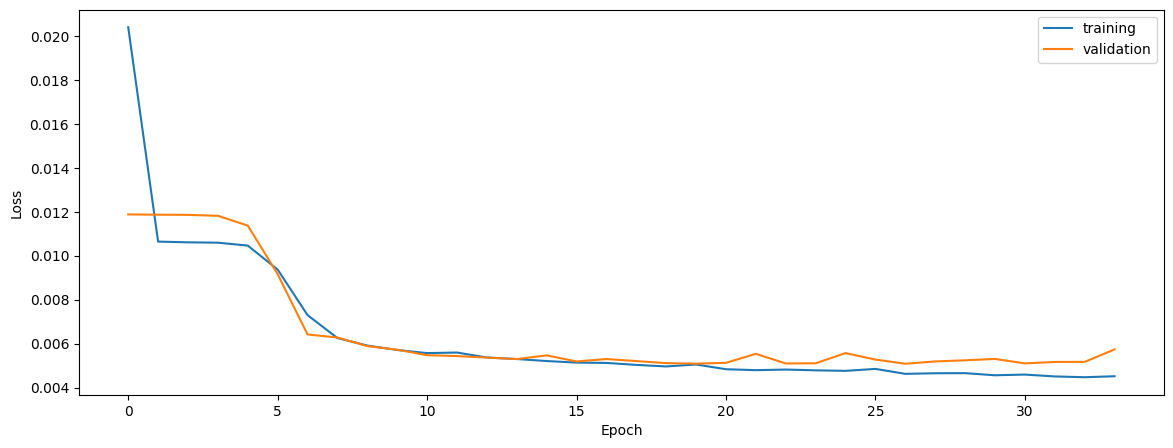

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7547078306724158
0.7564600917994194
0.7311329847274718


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7547078306724158
0.7564600917994194
0.7311329847274718


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7432341976312677
0.7431889834336697
0.7358047031546598


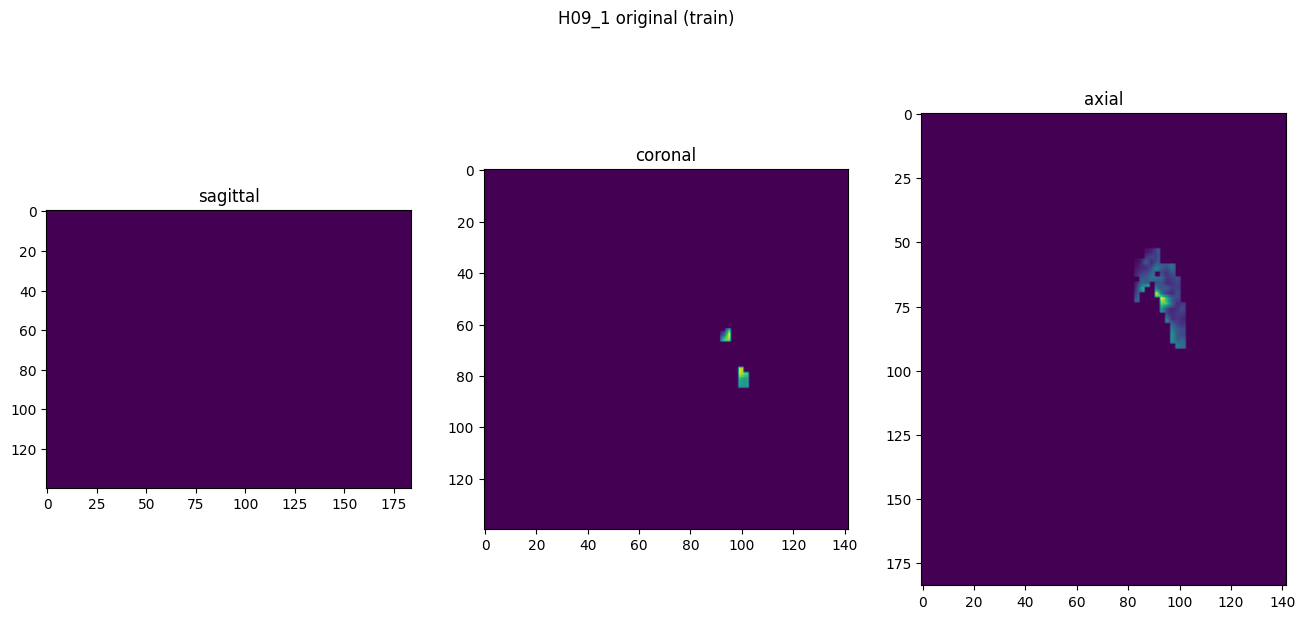

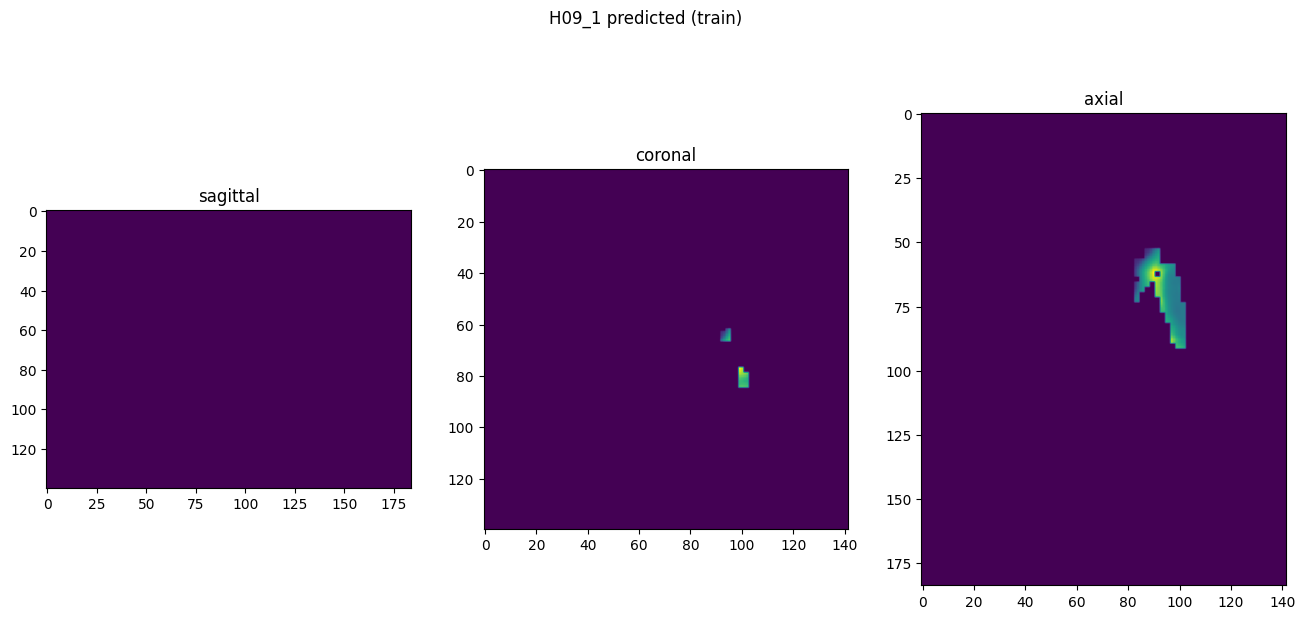

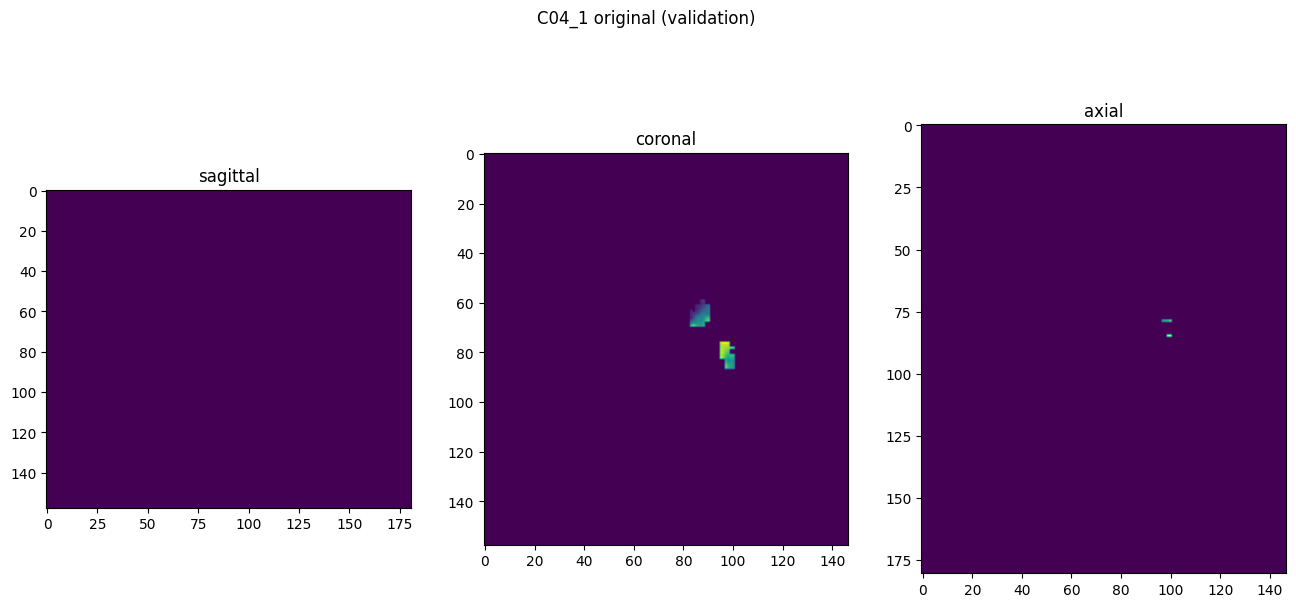

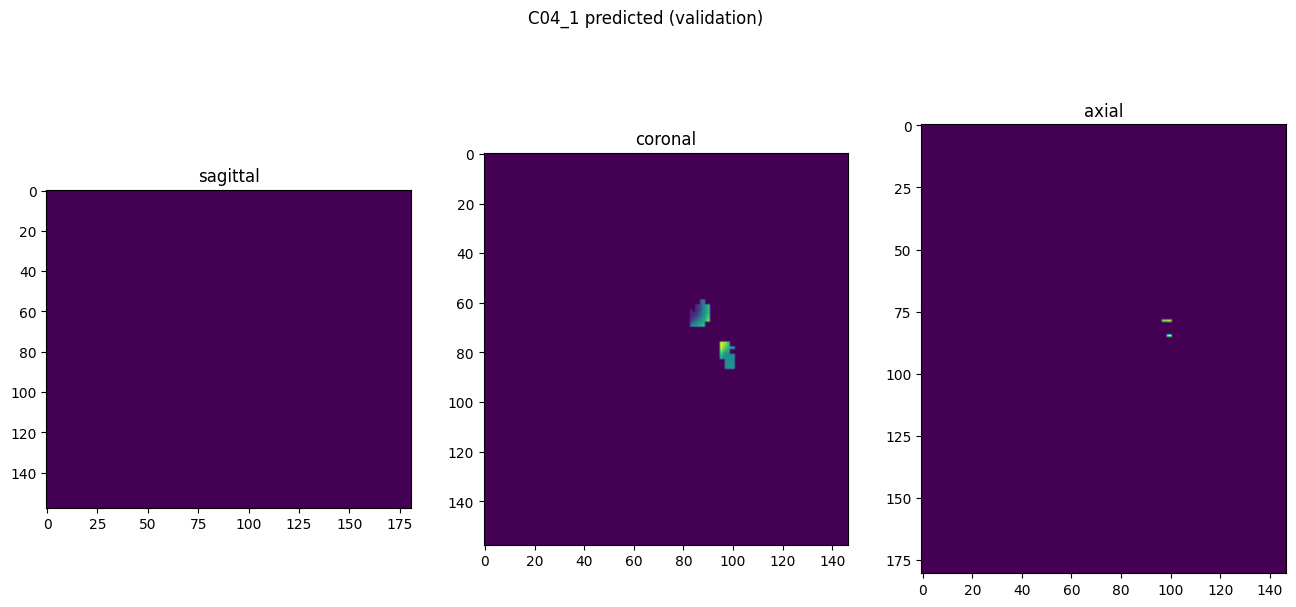

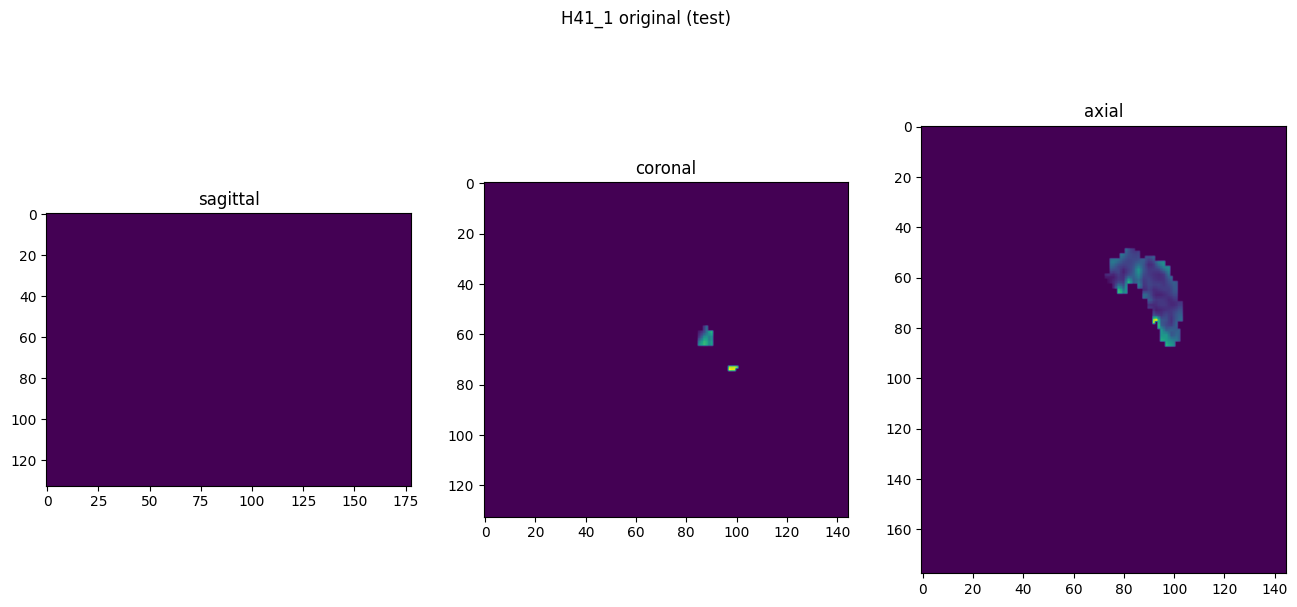

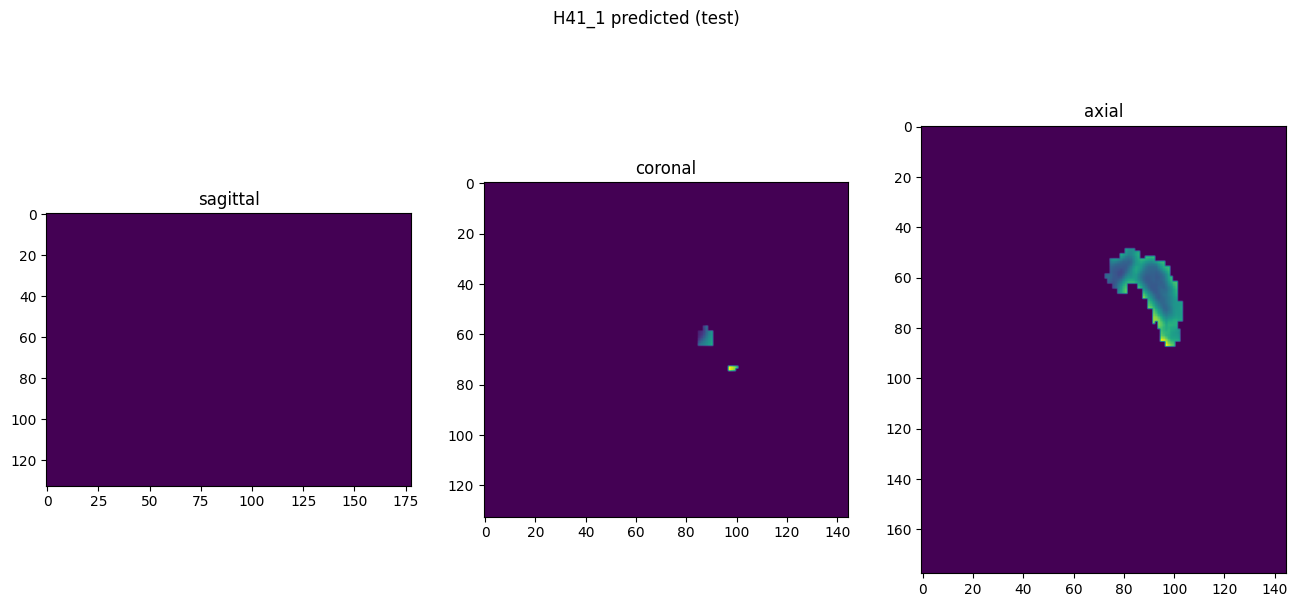

In [10]:
showResults(model, gen, threshold=None, background=False)